In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import u_net as unet
import skimage.io
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator

c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# Keras related
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [3]:
# Progress bar
from tqdm import tqdm

In [4]:
import random
import warnings
# Set some parameters
IMG_WIDTH = 128*2
IMG_HEIGHT = 128*2
IMG_CHANNELS = 3
TRAIN_PATH = 'data/'
TEST_PATH = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [5]:
import os
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids = next(os.walk(TEST_PATH))[1]

In [6]:
import sys
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# # Get and resize test images
# X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# sizes_test = []
# print('Getting and resizing test images ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#     path = TEST_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     sizes_test.append([img.shape[0], img.shape[1]])
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:13<00:00,  5.04it/s]


Done!


c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


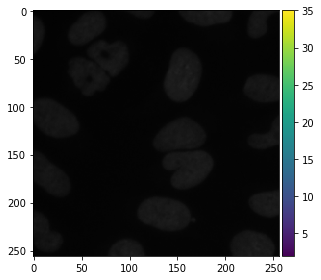

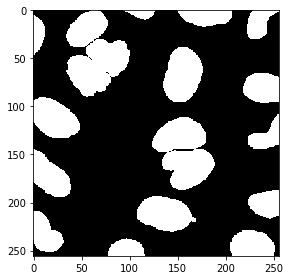

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [29]:
import keras
import numpy as np 
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Activation, Add, Concatenate, Dense
from keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D

""" Work with shitty network due to bad axis concatenation (not 0!)
    In UNet
"""

# model = unet.u_net(1, start=8, act="relu")

inputs = Input(shape=(256, 256, 3))
# Fourth/last block
fourth = MaxPooling2D()(inputs)
fourth = Conv2D(32, (3,3), padding="same")(fourth)
fourth = Activation(act)(fourth)
fourth = MaxPooling2D()(fourth)
fourth = Conv2D(64, (3,3), padding="same")(fourth)
fourth  = Activation(act)(fourth)

# STOP DOWNSAMPLING - START UPSAMPLING
# Reverse third - Upsampling conv (up-conv 2x2) as described in
# the original paper
r_third = UpSampling2D()(fourth)
r_third = Conv2D(64, (2,2), padding="same")(r_third)
r_third = Activation(act)(r_third)
r_third = UpSampling2D()(r_third)
r_third = Conv2D(32, (2,2), padding="same")(r_third)
r_third = Activation(act)(r_third)
# Normal part
r_first = Conv2D(1, (1,1), padding="same")(r_third)
outputs = Activation("sigmoid")(r_first)
model = Model(inputs=inputs, outputs=outputs)


loss = unet.IoU
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
activation_23 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_24 (Activation)   (None, 64, 64, 64)        0         
__________

In [30]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [21]:
def fuck_loss(y_true, y_pred):
    print(K.int_shape(y_true))
    print(K.int_shape(y_pred))
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [22]:
# #data augmentation
# datagen = ImageDataGenerator()
# datagen.fit(X_train)

In [31]:
# Rescale the data
# X_train /= 255
# Compile the model
model.compile(optimizer='adam', loss=fuck_loss, metrics=[mean_iou]) # mean_iou

(None, None, None, None)
(None, 256, 256, 1)


In [32]:
print(X_train.shape)

(670, 256, 256, 3)


In [33]:
print(Y_train.shape)

(670, 256, 256, 1)


In [34]:
# Ensure model works
preds = model.predict(X_train)

In [35]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=20, verbose=1) # callbacks=[earlystopper, checkpointer], 

Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - ETA: 19s - loss: 0.2041 - mean_iou: 0.0000e+0 - ETA: 14s - loss: 0.1835 - mean_iou: 0.2418    - ETA: 12s - loss: 0.1867 - mean_iou: 0.315 - ETA: 10s - loss: 0.1742 - mean_iou: 0.347 - ETA: 9s - loss: 0.1658 - mean_iou: 0.366 - ETA: 8s - loss: 0.1588 - mean_iou: 0.37 - ETA: 7s - loss: 0.1577 - mean_iou: 0.38 - ETA: 6s - loss: 0.1614 - mean_iou: 0.39 - ETA: 6s - loss: 0.1597 - mean_iou: 0.39 - ETA: 5s - loss: 0.1614 - mean_iou: 0.40 - ETA: 4s - loss: 0.1576 - mean_iou: 0.40 - ETA: 4s - loss: 0.1587 - mean_iou: 0.40 - ETA: 3s - loss: 0.1587 - mean_iou: 0.40 - ETA: 2s - loss: 0.1578 - mean_iou: 0.41 - ETA: 2s - loss: 0.1564 - mean_iou: 0.41 - ETA: 1s - loss: 0.1573 - mean_iou: 0.41 - ETA: 1s - loss: 0.1577 - mean_iou: 0.41 - ETA: 0s - loss: 0.1574 - mean_iou: 0.41 - 11s 19ms/step - loss: 0.1572 - mean_iou: 0.4157 - val_loss: 0.1433 - val_mean_iou: 0.4282
Epoch 2/20
603/603 [==================

KeyboardInterrupt: 

In [36]:
# Predict on train set
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)

603/603 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 4ms/step


c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


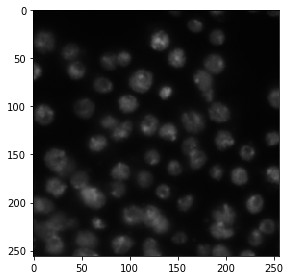

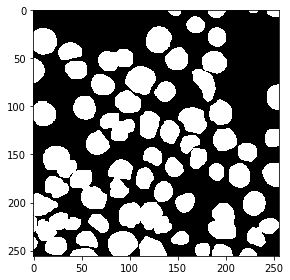

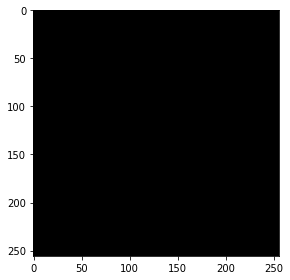

In [37]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()